In [1]:
import numpy as np
import pandas as pd

import random
import os
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
hdu_list = fits.open('Unique_positives_complete_fixed.fits')
print('Num. single candidates: ', len(hdu_list[1].data))
images_sing = hdu_list[1].data
images_sing = images_sing[:,0:3,:,:]
data_sing = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

filepath = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn_multiclass_double/results/'
hdu_list = fits.open(filepath + 'Unique_double_complete.fits')
print('Num. double candidates: ', len(hdu_list[1].data))
images_doub = hdu_list[1].data
images_doub = images_doub[:,0:3,:,:]
data_doub = pd.DataFrame(hdu_list[2].data)
mask = data_doub['COADD_OBJECT_ID'].isin(data_sing['COADD_OBJECT_ID'])
duplicated = data_doub[mask]
print('Num. in intersection: ', len(duplicated))
data_doub = data_doub.drop(duplicated.index)
images_doub = images_doub[data_doub.index]
hdu_list.close()

images = np.concatenate((images_sing, images_doub)).astype(np.float32)
data = pd.concat([data_sing, data_doub], axis=0).reset_index(drop=True)

print('Num. total candidates: ', len(images), len(data))

Num. single candidates:  20653
Num. double candidates:  2538
Num. in intersection:  491
Num. total candidates:  22700 22700


In [3]:
known_data = pd.read_csv('SLED_lens_database.csv')
print(len(known_data))

print('Confirmed: ', len(known_data[known_data['flag_confirmed'] == True]))
print('Not confirmed: ', len(known_data[known_data['flag_confirmed'] == False]))
print(' ')
print('Galaxy lensing: ', len(known_data[known_data['type'] == 'GAL']))
print('QSO lensing: ', len(known_data[known_data['type'] == 'QSO']))
print('SN lensing: ', len(known_data[known_data['type'] == 'SN']))

known_data.head()

14938
Confirmed:  818
Not confirmed:  14120
 
Galaxy lensing:  13037
QSO lensing:  1896
SN lensing:  5


,name,ra,dec,bibcode,flag_confirmed,type
0,SDSSJ0058-1020,14.52800,-10.33700,2017ApJ...851...48S,False,GAL
1,SDSSJ0139-1035,24.88329,-10.58431,2017ApJ...851...48S,False,GAL
2,SDSSJ0143-1006,25.98575,-10.10936,2017ApJ...851...48S,True,GAL
3,SDSSJ0159-0006,29.87558,-0.10344,2017ApJ...851...48S,True,GAL
4,SDSSJ0206+0115,31.74983,1.25481,2017ApJ...851...48S,False,GAL


In [4]:
size = 0.0032
numpix = 45
images_det, data_det = np.zeros((1,3,numpix,numpix)), pd.DataFrame(columns = data.columns)
counter = 0

for i in range(len(known_data)):
    if(i > 200): break
    ra, dec = known_data['ra'].iloc[i], known_data['dec'].iloc[i]
    data_tmp = data[data['RA'] > ra - size][data['RA'] < ra + size][data['DEC'] > dec - size][data['DEC'] < dec + size]
    #for (index, row) in data_tmp.iterrows():
    if(len(data_tmp)>0):
        counter += 1
        images_det = np.append(images_det, images[data_tmp.index], axis = 0)
        data_det = data_det.append(data_tmp)
        
images_det = np.delete(images_det, 0, axis = 0)
print(len(images_det), len(data_det))
print('Unique number: ' + str(counter))

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == "__main__":


116 116
Unique number: 112


In [5]:
size = 0.0032
numpix = 45
columns = list(data.columns) + list(known_data.columns)

images_det, data_det = np.zeros((1,3,numpix,numpix)), pd.DataFrame(columns = columns)
counter = 0

for (i_index, row) in known_data.iterrows():
    #if(i_index > 200): break
    ra, dec = row['ra'], row['dec']
    data_tmp = data[data['RA'] > ra - size][data['RA'] < ra + size][data['DEC'] > dec - size][data['DEC'] < dec + size]
    if(len(data_tmp) > 0): counter += 1
    for (j_index, j_row) in data_tmp.iterrows():
        new_row = pd.concat([row, j_row])
        data_det = data_det.append(new_row, ignore_index=True)
        images_det = np.append(images_det, [images[j_index]], axis = 0)
        
images_det = np.delete(images_det, 0, axis = 0)
print(len(images_det), len(data_det))
print('Unique number: ' + str(counter))

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


1454 1454
Unique number: 1427


In [6]:
print('Confirmed: ', len(data_det[data_det['flag_confirmed'] == True]))
print('Not confirmed: ', len(data_det[data_det['flag_confirmed'] == False]))
print(' ')
print('Galaxy lensing: ', len(data_det[data_det['type'] == 'GAL']))
print('QSO lensing: ', len(data_det[data_det['type'] == 'QSO']))
print('SN lensing: ', len(data_det[data_det['type'] == 'SN']))

Confirmed:  2
Not confirmed:  1452
 
Galaxy lensing:  1452
QSO lensing:  2
SN lensing:  0


In [7]:
def make_plot_all(objects, title, data):
    #print(title)
    for i in range(len(objects)):
        if(i%6 == 0):
            plt.figure(figsize=(16,9))
            for j in range(6):
                if(i+j > len(objects)-1): break
                plt.subplot(1,6,j+1)
                #print(data['COADD_OBJECT_ID'].iloc[i+j], data['MAG_AUTO_G'].iloc[i+j])
                new_title = 'Prob: {:.4f}'.format(data['PROB'].iloc[i+j])
                plt.title(new_title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Confirmed:


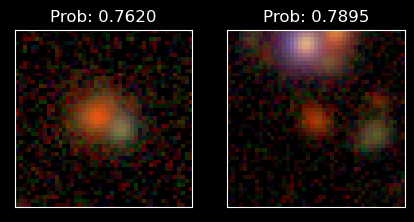

QSO:


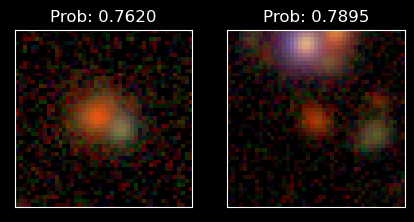

In [8]:
print('Confirmed:')
make_plot_all(images_det[data_det[data_det['flag_confirmed'] == True].index], 'title', data_det[data_det['flag_confirmed'] == True])
print('QSO:')
make_plot_all(images_det[data_det[data_det['type'] == 'QSO'].index], 'title', data_det[data_det['type'] == 'QSO'])

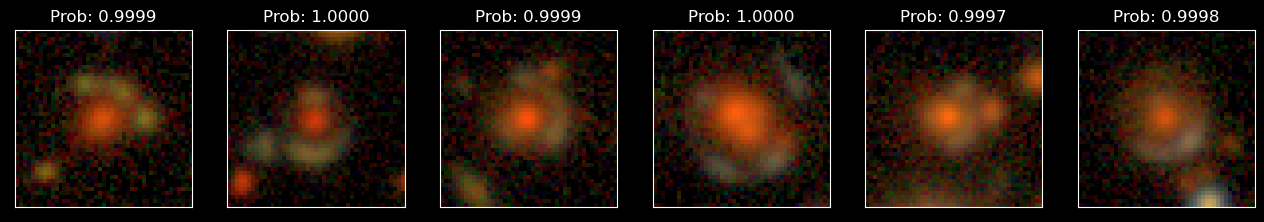

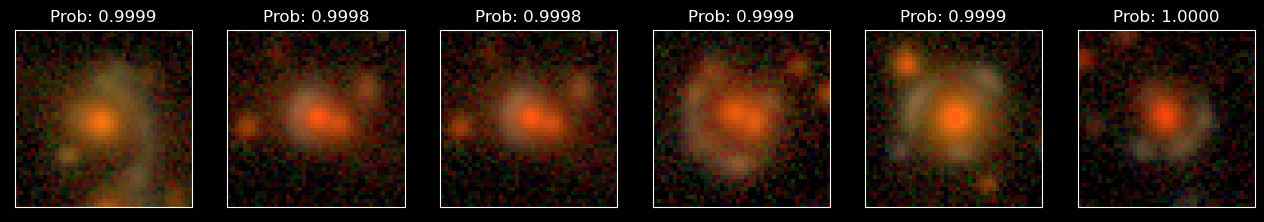

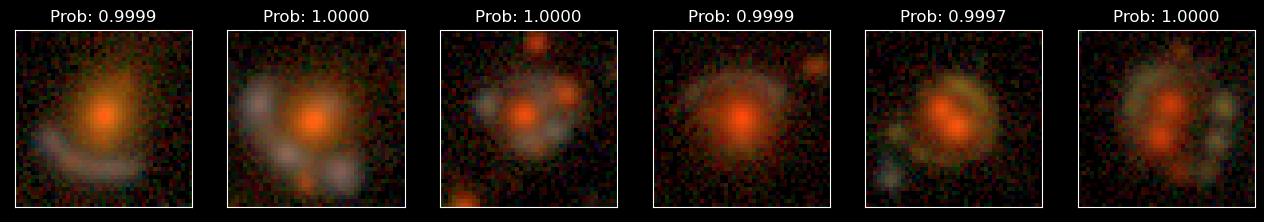

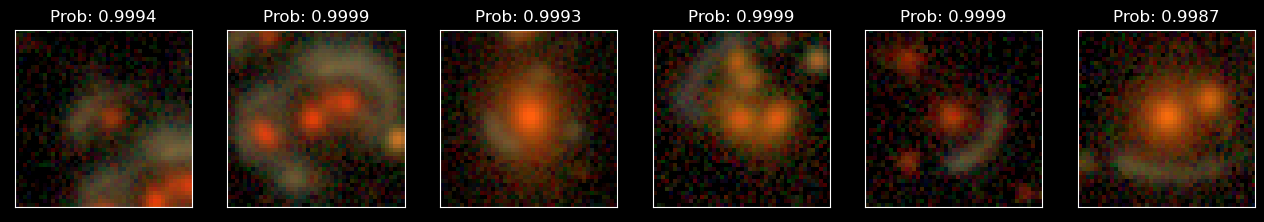

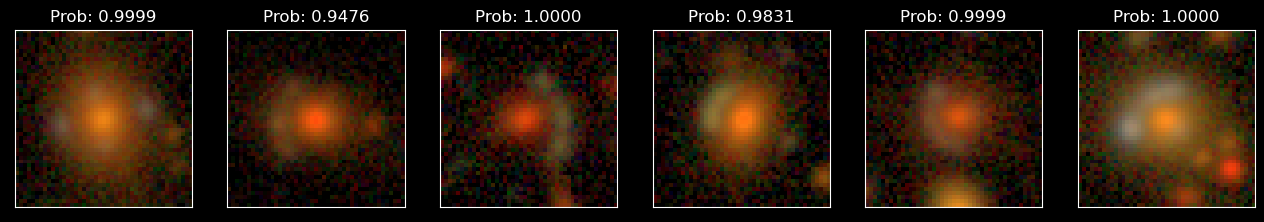

In [9]:
N = 30
make_plot_all(images_det[0:30], 'title', data_det.iloc[0:30])